#### 1) Prepare environment.

In [1]:
import io
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import preprocessing
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

Authenticated


#### 2) Connect to GCP and create master table from DB.

In [6]:
project_id = 'capstone2020-283620'
client = bigquery.Client(project=project_id)

master = client.query('''
SELECT
  master.Sum_nombre_incidents Target,
  master.date_range Date,
  master.firestation Station,
  CASE WHEN master.shift_key=1 THEN 'Night'
        WHEN master.shift_key=2 THEN 'Day'
        WHEN master.shift_key=3 THEN 'Evening' END AS Shift,
  master.year_key as Year,
  master.month_key as Month,
  master.day_key as Day,
  #master.ratio_unite_appels,
  #CASE WHEN events.Target IS NOT NULL THEN events.Target ELSE 0 END AS Target ,
  #frame.Station,
  #frame.Date,
  #frame.Shift,
  socio.Sum_age_0_14,
  socio.Sum_age_15_64,
  socio.Sum_age_65,
  socio.Sum_Income_10k,
  socio.Sum_Income_20k,
  socio.Sum_Income_30k,
  socio.Sum_Income_40k,
  socio.Sum_Income_50k,
  socio.Sum_Income_60k,
  socio.Sum_Income_70k,
  socio.Sum_Income_80k,
  socio.Sum_Income_90k,
  socio.Sum_Income_100k,
  socio.Sum_Pop_total,
  CASE WHEN house.COOP_sum IS NOT NULL THEN house.COOP_sum ELSE 0 END AS COOP_sum,
  CASE WHEN house.HLM_sum  IS NOT NULL THEN house.HLM_sum  ELSE 0 END AS HLM_sum,
  CASE WHEN house.OBNL_sum IS NOT NULL THEN house.OBNL_sum ELSE 0 END AS OBNL_sum,
  CASE WHEN house.OMHM_sum IS NOT NULL THEN house.OMHM_sum ELSE 0 END AS OMHM_sum,
  CASE WHEN house.SHDM_sum IS NOT NULL THEN house.SHDM_sum ELSE 0 END AS SHDM_sum,
  CASE WHEN holiday.Holiday IS NOT NULL THEN holiday.Holiday ELSE 0 END AS Holiday,
  weather.Temp_DC_Mean,
  weather.Humid_percent_Mean,
  weather.Win_Dir_Mean,
  weather.Wind_Speed_Mean,
  weather.Stn_Press_Mean,
  weather.Temp_DC_Max,
  weather.Humid_percent_Max,
  weather.Win_Dir_Max,
  weather.Wind_Speed_Max,
  weather.Stn_Press_Max,
  weather.Temp_DC_Min,
  weather.Humid_percent_Min,
  weather.Win_Dir_Min,
  weather.Wind_Speed_Min,
  weather.Stn_Press_Min,
  habs.Mtl_win,
  habs.Mtl_played,
  moon.Full_moon
FROM `capstone2020-283620.capstone2020.sim_incidents` master 

# FR-Calls aggregated table
#LEFT JOIN
#  (SELECT 
#    COUNT(*)    AS Target,
#    CAST(CASERNE AS INT64)    AS Station,
#    Date        AS Date,
#    CASE WHEN shift=1 THEN 'Night'
#        WHEN shift=2 THEN 'Day'
#        WHEN shift=3 THEN 'Evening' END AS Shift
#  FROM `capstone2020-283620.capstone2020.master_table` 
#  GROUP BY Station, Date, Shift) events
#ON frame.Station=events.Station AND frame.Date=events.Date AND frame.Shift=events.Shift

# Joining soci-demo table
LEFT JOIN `capstone2020-283620.capstone2020.detailed_socio_profiles` socio
ON master.firestation=socio.NO_CAS_ADM

# Joining social-housing table
LEFT JOIN `capstone2020-283620.capstone2020.social_housing` house
ON master.firestation=house.Station

# Joining holiday_qc table
LEFT JOIN `capstone2020-283620.capstone2020.holiday` holiday
ON master.date_range=holiday.Date

# Weather
LEFT JOIN `capstone2020-283620.capstone2020.weather` weather
ON master.date_range=weather.Date AND master.shift_key=weather.Shift

# Habs schedule
LEFT JOIN `capstone2020-283620.capstone2020.ch_games_fin` habs
ON master.date_range=habs.date AND master.shift_key=habs.Period

# Moon Cycles
LEFT JOIN `capstone2020-283620.capstone2020.moon_cycles` moon
ON master.date_range = moon.date  AND master.shift_key=moon.Period

''').to_dataframe()

In [7]:
master.head()

,Target,Date,Station,Shift,Year,Month,Day,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Sum_Pop_total,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Holiday,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Mtl_win,Mtl_played,Full_moon
0,0,2005-01-01,2,Night,2005,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,5.2250,73.625,26.250,34.375,100.90750,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,NaN,NaN,NaN
1,0,2005-01-01,2,Day,2005,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,0.6250,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.60,NaN,NaN,NaN
2,0,2005-01-01,2,Evening,2005,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,-5.5750,52.250,21.500,18.500,103.31750,-1.9,57.0,36.0,28.0,103.64,-9.5,49.0,2.0,11.0,102.86,NaN,NaN,0.0
3,0,2005-01-02,2,Night,2005,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,-13.8750,64.250,4.750,21.500,103.78125,-10.7,69.0,6.0,24.0,103.83,-15.9,59.0,3.0,19.0,103.69,NaN,NaN,NaN
4,0,2005-01-02,2,Day,2005,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,-13.9375,76.500,4.625,23.250,102.97750,-11.2,87.0,6.0,28.0,103.63,-15.8,71.0,4.0,20.0,102.19,NaN,NaN,NaN


#### 3) Cleaning of master table and create features.

In [8]:
master[['Mtl_played', 'Mtl_win', 'Full_moon']] = master[['Mtl_played', 'Mtl_win', 'Full_moon']].fillna(value=0)

In [9]:
master=master.fillna(master.mean())

col_to_prep = ['Sum_age_0_14', 'Sum_age_15_64', 'Sum_age_65', 'Sum_Income_10k', 'Sum_Income_20k', 'Sum_Income_30k', 
               'Sum_Income_40k', 'Sum_Income_50k', 'Sum_Income_60k', 'Sum_Income_70k', 'Sum_Income_80k', 'Sum_Income_90k', 
               'Sum_Income_100k']
for col in col_to_prep:
  master[col] = master[col]/master['Sum_Pop_total']


# On retravaille un peu le format de dates
master['DateFMT'] = pd.to_datetime(master['Date'])
master = master.drop('Date', axis=1)

In [10]:
# Preparation
master=master.sort_values(by=['DateFMT','Shift','Station'])
master['WeekDay'] = master['DateFMT'].dt.dayofweek
master["Month"]   = master['DateFMT'].dt.month
master_clean = master.set_index('DateFMT')
master_clean.head()

,Target,Station,Shift,Year,Month,Day,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Sum_Pop_total,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Holiday,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Mtl_win,Mtl_played,Full_moon,WeekDay
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0,2,Day,2005,1,1,0.156628,0.678199,0.165214,0.155871,0.120217,0.096177,0.078764,0.055924,0.039088,0.029904,0.020946,0.014297,0.051820,20973.30303,0.0,0.0,0.0,0.0,0.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5
2005-01-01,0,3,Day,2005,1,1,0.118366,0.777388,0.104530,0.138173,0.087377,0.067002,0.067381,0.055629,0.050322,0.042077,0.033453,0.028525,0.108795,10552.00000,634.0,876.0,283.0,26.0,29.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5
2005-01-01,1,4,Day,2005,1,1,0.168830,0.685857,0.145313,0.162507,0.133444,0.093123,0.063672,0.041043,0.028841,0.022352,0.015585,0.011481,0.051359,18030.00000,298.0,454.0,1189.0,67.0,384.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5
2005-01-01,0,5,Day,2005,1,1,0.063436,0.785372,0.151131,0.178847,0.106617,0.082115,0.066590,0.052095,0.038874,0.031536,0.021833,0.015162,0.058403,16489.00000,133.0,1112.0,186.0,0.0,64.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5
2005-01-01,1,8,Day,2005,1,1,0.145754,0.674081,0.180296,0.159187,0.133019,0.121244,0.099874,0.071438,0.044354,0.028654,0.017925,0.009900,0.018230,22929.00000,0.0,0.0,0.0,0.0,0.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5


In [11]:
def create_lag(df, p, sortList, partList, lagList):
    """
    Cette fonction prend comme intrant un df, une liste de variables pour lesquelles il faut
    creer des valeurs retardees, le nombre de retard, les variables sur lesquelles il faut sort,
    les variables de partition et la liste de varibles pour lesquelles on veut des valeurs retardees.
    La fonction retourne un df augmente des variables retardees
    """
    df = df.sort_values(by=sortList)
    
    for feature in lagList:
        for i in range(p):
            df['{}.L{}'.format(feature,i+1)] = df.groupby(partList)[feature].shift(i+1)
    
    return df

In [12]:
mean = master_clean[['Station','Target']].groupby(['Station']).mean()
median = master_clean[['Station','Target']].groupby(['Station']).median()

mean = mean.rename(columns={'Target': 'Target_mean'})
median = median.rename(columns={'Target': 'Target_median'})

total = mean.join(median)
total = total.reset_index()
master_clean = master_clean.reset_index()
master_clean = pd.merge(master_clean, total,  how='left', left_on=['Station'], right_on = ['Station'])
master_clean = master_clean.set_index('DateFMT')
master_clean.head()

,Target,Station,Shift,Year,Month,Day,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Sum_Pop_total,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Holiday,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Mtl_win,Mtl_played,Full_moon,WeekDay,Target_mean,Target_median
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0,2,Day,2005,1,1,0.156628,0.678199,0.165214,0.155871,0.120217,0.096177,0.078764,0.055924,0.039088,0.029904,0.020946,0.014297,0.051820,20973.30303,0.0,0.0,0.0,0.0,0.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5,0.000000,0
2005-01-01,0,3,Day,2005,1,1,0.118366,0.777388,0.104530,0.138173,0.087377,0.067002,0.067381,0.055629,0.050322,0.042077,0.033453,0.028525,0.108795,10552.00000,634.0,876.0,283.0,26.0,29.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5,0.511351,0
2005-01-01,1,4,Day,2005,1,1,0.168830,0.685857,0.145313,0.162507,0.133444,0.093123,0.063672,0.041043,0.028841,0.022352,0.015585,0.011481,0.051359,18030.00000,298.0,454.0,1189.0,67.0,384.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5,1.522644,1
2005-01-01,0,5,Day,2005,1,1,0.063436,0.785372,0.151131,0.178847,0.106617,0.082115,0.066590,0.052095,0.038874,0.031536,0.021833,0.015162,0.058403,16489.00000,133.0,1112.0,186.0,0.0,64.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5,2.144821,2
2005-01-01,1,8,Day,2005,1,1,0.145754,0.674081,0.180296,0.159187,0.133019,0.121244,0.099874,0.071438,0.044354,0.028654,0.017925,0.009900,0.018230,22929.00000,0.0,0.0,0.0,0.0,0.0,1,0.625,65.875,28.875,24.375,102.17375,2.6,78.0,30.0,28.0,102.71,-1.1,54.0,27.0,19.0,101.6,0.0,0.0,0.0,5,0.507757,0


In [17]:
master_clean.describe()

,Target,Station,Year,Month,Day,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Sum_Pop_total,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Holiday,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Mtl_win,Mtl_played,Full_moon,WeekDay,Target_mean,Target_median
count,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06,1.192176e+06
mean,1.293825e+00,4.111765e+01,2.012501e+03,6.522930e+00,1.572964e+01,1.521739e-01,6.844355e-01,1.634431e-01,1.515675e-01,1.157930e-01,9.353773e-02,7.807104e-02,5.646113e-02,4.030407e-02,3.138027e-02,2.227922e-02,1.544331e-02,5.980123e-02,2.097330e+04,2.033676e+02,3.006176e+02,2.650882e+02,2.750000e+01,6.775000e+01,2.395619e-03,7.713160e+00,6.906427e+01,1.911289e+01,1.448836e+01,1.011098e+02,9.624115e+00,7.775757e+01,2.434076e+01,2.011669e+01,1.012575e+02,5.648244e+00,6.074586e+01,1.418105e+01,9.183561e+00,1.009582e+02,2.127538e-02,3.941364e-02,1.425964e-03,2.999829e+00,1.293825e+00,9.705882e-01
std,1.580445e+00,2.183059e+01,4.609848e+00,3.448705e+00,8.800096e+00,3.399370e-02,5.885492e-02,3.687366e-02,2.702283e-02,2.052602e-02,1.538591e-02,1.308203e-02,9.489112e-03,7.840769e-03,7.421989e-03,6.201666e-03,5.504451e-03,4.291042e-02,7.949946e+03,2.728977e+02,3.338631e+02,3.823978e+02,5.705920e+01,1.168185e+02,4.888642e-02,1.102112e+01,1.471914e+01,8.317146e+00,6.835023e+00,8.439253e-01,1.131072e+01,1.294477e+01,9.239326e+00,8.163376e+00,8.329554e-01,1.075264e+01,1.644352e+01,9.558506e+00,6.375312e+00,8.588253e-01,1.443009e-01,1.945771e-01,3.773502e-02,2.000129e+00,7.113397e-01,7.469665e-01
min,0.000000e+00,2.000000e+00,2.005000e+03,1.000000e+00,1.000000e+00,6.343623e-02,5.646682e-01,9.374545e-02,8.975085e-02,6.815590e-02,5.369951e-02,5.115138e-02,3.492992e-02,1.798938e-02,1.036138e-02,6.261323e-03,2.955853e-03,4.831071e-03,3.957000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.673750e+01,1.712500e+01,1.125000e+00,0.000000e+00,9.736625e+01,-2.630000e+01,2.100000e+01,2.000000e+00,0.000000e+00,9.750000e+01,-2.740000e+01,1.100000e+01,0.000000e+00,0.000000e+00,9.712000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.275000e+01,2.008750e+03,4.000000e+00,8.000000e+00,1.344140e-01,6.472800e-01,1.374489e-01,1.348943e-01,9.999204e-02,8.237518e-02,6.655065e-02,5.159638e-02,3.671186e-02,2.805996e-02,1.853368e-02,1.179438e-02,2.812081e-02,1.635125e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e-01,6.037500e+01,1.375000e+01,9.500000e+00,1.005962e+02,1.900000e+00,7.100000e+01,2.100000e+01,1.500000e+01,1.007400e+02,-8.000000e-01,5.000000e+01,3.000000e+00,4.000000e+00,1.004400e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.300365e-01,0.000000e+00
50%,1.000000e+00,4.150000e+01,2.012500e+03,7.000000e+00,1.600000e+01,1.569623e-01,6.692669e-01,1.642444e-01,1.545957e-01,1.189614e-01,9.584519e-02,7.876391e-02,5.737869e-02,4.111565e-02,3.198115e-02,2.175632e-02,1.467340e-02,5.037329e-02,2.051800e+04,8.050000e+01,2.425000e+02,1.225000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.713160e+00,6.906427e+01,2.087500e+01,1.375000e+01,1.011098e+02,9.624115e+00,7.775757e

In [23]:
#Faire les list:
vars_to_lag = ['Target']

df_eng = create_lag(df=master_clean, 
                    p=7,
                    sortList=['DateFMT','Shift','Station'],
                    partList=['Shift','Station'],
                    lagList=vars_to_lag)

#Separation des features
y = df_eng[['Target']]
X_cont = df_eng[['COOP_sum', 'HLM_sum', 'OBNL_sum','OMHM_sum', 'SHDM_sum','Target.L1',
                'Target.L2', 'Target.L3', 'Target.L4', 'Target.L5', 'Target.L6', 'Target.L7',
                 'Temp_DC_Mean', 'Humid_percent_Mean', 'Win_Dir_Mean', 'Wind_Speed_Mean', 
                 'Stn_Press_Mean', 'Temp_DC_Max', 'Humid_percent_Max', 'Win_Dir_Max', 'Wind_Speed_Max', 
                 'Stn_Press_Max', 'Temp_DC_Min', 'Humid_percent_Min', 'Win_Dir_Min', 'Wind_Speed_Min', 
                 'Stn_Press_Min', 'Target_mean', 'Target_median','Sum_age_0_14', 'Sum_age_15_64', 
                 'Sum_age_65', 'Sum_Income_10k', 'Sum_Income_20k', 'Sum_Income_30k', 'Sum_Income_40k', 
                 'Sum_Income_50k', 'Sum_Income_60k', 'Sum_Income_70k', 'Sum_Income_80k', 
                 'Sum_Income_90k','Sum_Income_100k', 'Mtl_played', 'Mtl_win', 'Full_moon']]
X_cat = df_eng[['Shift','WeekDay', 'Month', 'Holiday']]

In [24]:
scaler = preprocessing.StandardScaler().fit(X_cont)
X_cont_scaled = scaler.fit_transform(X_cont.values)
X_cont = pd.DataFrame(X_cont_scaled, index=X_cont.index, columns=X_cont.columns)

In [25]:
X = X_cont
for col in X_cat.columns:
  datas = pd.get_dummies(X_cat[col], prefix=col, prefix_sep='_')
  X     = pd.concat([X, datas], axis=1)
X = X.dropna()

In [26]:
X = X.drop(['Holiday_0', 'Month_1', 'WeekDay_0', 'Shift_Day'], axis=1)
X.head()

,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Target.L1,Target.L2,Target.L3,Target.L4,Target.L5,Target.L6,Target.L7,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Target_mean,Target_median,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Mtl_played,Mtl_win,Full_moon,Shift_Evening,Shift_Night,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Holiday_1
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-08,-0.745216,-0.900422,-0.693227,-0.481956,-0.579960,-0.818764,-0.818881,-0.818998,-0.819115,-0.819232,-0.819349,-0.819467,-0.915348,0.479697,-1.559433,-1.150451,0.869629,-0.974661,0.173231,-1.119211,-1.11678,0.795359,-0.841491,0.684412,-1.274368,-1.440489,0.921935,-1.818857,-1.299374,0.131040,-0.105962,0.048035,0.159239,0.215535,0.171545,0.052964,-0.056614,-0.155104,-0.198929,-0.215006,-0.208311,-0.186001,-0.202561,-0.147438,-0.037789,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2005-01-08,1.578000,1.723409,0.046841,-0.026288,-0.331711,-0.818764,-0.818881,-0.186318,-0.819115,0.446057,-0.819349,-0.819467,-0.915348,0.479697,-1.559433,-1.150451,0.869629,-0.974661,0.173231,-1.119211,-1.11678,0.795359,-0.841491,0.684412,-1.274368,-1.440489,0.921935,-1.100001,-1.299374,-0.994529,1.579353,-1.597704,-0.495679,-1.384398,-1.724709,-0.817186,-0.087665,1.277700,1.441267,1.801800,2.376639,1.141758,-0.202561,-0.147438,-0.037789,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2005-01-08,0.346769,0.459417,2.416102,0.692264,2.707193,-0.818764,1.079213,-0.186318,-0.186453,-0.186588,1.078531,-0.186858,-0.915348,0.479697,-1.559433,-1.150451,0.869629,-0.974661,0.173231,-1.119211,-1.11678,0.795359,-0.841491,0.684412,-1.274368,-1.440489,0.921935,0.321674,0.039375,0.489968,0.024151,-0.491672,0.404822,0.859947,-0.026983,-1.100700,-1.624855,-1.462006,-1.216471,-1.079401,-0.719862,-0.196744,-0.202561,-0.147438,-0.037789,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2005-01-08,-0.257854,2.430285,-0.206822,-0.481956,-0.032101,-0.818764,-0.186183,-0.818998,-0.819115,0.446057,0.445904,-0.819467,-0.915348,0.479697,-1.559433,-1.150451,0.869629,-0.974661,0.173231,-1.119211,-1.11678,0.795359,-0.841491,0.684412,-1.274368,-1.440489,0.921935,1.196329,1.378124,-2.610416,1.715007,-0.333899,1.009480,-0.447064,-0.742393,-0.877631,-0.460085,-0.182338,0.021006,-0.071994,-0.051175,-0.032595,-0.202561,-0.147438,-0.037789,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2005-01-08,-0.745216,-0.900422,-0.693227,-0.481956,-0.579960,-0.818764,-0.818881,-0.818998,-0.819115,-0.186588,-0.186723,-0.186858,-0.915348,0.479697,-1.559433,-1.150451,0.869629,-0.974661,0.173231,-1.119211,-1.11678,0.795359,-0.841491,0.684412,-1.274368,-1.440489,0.921935,-1.105053,-1.299374,-0.188847,-0.175935,0.457036,0.281967,0.839245,1.800746,1.666599,1.578314,0.516562,-0.367368,-0.702121,-1.007037,-0.968787,-0.202561,-0.147438,-0.037789,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3) Train, test, and valid split.

In [27]:
from sklearn.model_selection import TimeSeriesSplit

In [28]:
# Validation set will be 2019 data
#X_valid, y_valid = X.loc['2019-01-01':'2019-12-31'], y.loc['2019-01-01':'2019-12-31']
#X_ts, y_ts = X.loc['2015-01-08':'2018-12-31'].reset_index(), y.loc['2015-01-08':'2018-12-31'].reset_index()

# TimeSeriesSplit for <cross-validation> like method used for TS
#tscv = TimeSeriesSplit()
#for train_index, test_index in tscv.split(X_ts):
#  print("TRAIN:", train_index, "TEST:", test_index)
#  X_train, X_test = X_ts[train_index], X_ts[test_index]
#  y_train, y_test = y_ts[train_index], y_ts[test_index]

In [29]:
# Validation set will be 2019 data
X_test = X.loc['2019-01-01':'2019-12-31']
y_test = y.loc['2019-01-01':'2019-12-31']

# Train/test split using data from 2015 to 2018
X_train, X_valid, y_train, y_valid = train_test_split(X.loc['2005-01-08':'2018-12-31'], y.loc['2005-01-08':'2018-12-31'], test_size=0.33, random_state=42)

print('Valid X y : ', len(X_valid), '--', len(y_valid))
print('Train X y : ', len(X_train), '--', len(y_train))
print('Test X y: '  , len(X_test), '--', len(y_test))

Valid X y :  343736 -- 343736
Train X y :  697888 -- 697888
Test X y:  74460 -- 74460


#### 4) Modelling.

##### Baseline

In [30]:
# The baseline is the number of events one week before the actual prediction (same shift and station) 
bl_test = X_test[['Target.L7']]
bl_train = X_train[['Target.L7']]
bl_valid = X_valid[['Target.L7']]

##### Linear Regression

In [31]:
lin_reg = LinearRegression().fit(X_train, y_train)

##### Gradient Boosting Regressor

In [71]:
params = {'n_estimators': 500,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'lad'}


gbm_reg = ensemble.GradientBoostingRegressor(**params)
gbm_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

##### Neural Network




In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.3.0


In [73]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
  return model

In [74]:
model = build_model()

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


In [76]:
h = model.fit(x = X_train, y = y_train, validation_split = 0.33, epochs = 10)

Epoch 1/10
14612/14612 [==============================] - 25s 2ms/step - loss: 1.6147 - mae: 0.9129 - mse: 1.6147 - val_loss: 1.5799 - val_mae: 0.9268 - val_mse: 1.5799
Epoch 2/10
14612/14612 [==============================] - 25s 2ms/step - loss: 1.5858 - mae: 0.9046 - mse: 1.5858 - val_loss: 1.5829 - val_mae: 0.8947 - val_mse: 1.5829
Epoch 3/10
14612/14612 [==============================] - 25s 2ms/step - loss: 1.5823 - mae: 0.9031 - mse: 1.5823 - val_loss: 1.5747 - val_mae: 0.9154 - val_mse: 1.5747
Epoch 4/10
14612/14612 [==============================] - 26s 2ms/step - loss: 1.5798 - mae: 0.9024 - mse: 1.5798 - val_loss: 1.5693 - val_mae: 0.8888 - val_mse: 1.5693
Epoch 5/10
14612/14612 [==============================] - 24s 2ms/step - loss: 1.5796 - mae: 0.9022 - mse: 1.5796 - val_loss: 1.5601 - val_mae: 0.8995 - val_mse: 1.5601
Epoch 6/10
14612/14612 [==============================] - 24s 2ms/step - loss: 1.5763 - mae: 0.9006 - mse: 1.5763 - val_loss: 1.5747 - val_mae: 0.8898 - va

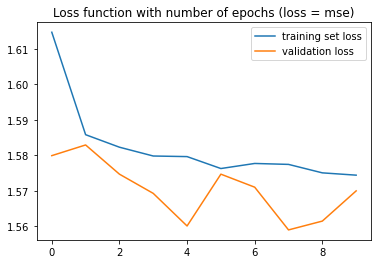

In [78]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.legend(['training set loss','validation loss'])

plt.title('Loss function with number of epochs (loss = mse)')

plt.show()

#### 5) Results

##### Model Performance

In [84]:
from sklearn.metrics import mean_squared_error

# Mean Square Error

# training set
mse_bl_train = mean_squared_error(y_train, bl_train)
mse_lin_train = mean_squared_error(y_train, lin_reg.predict(X_train))
mse_gbm_train = mean_squared_error(y_train, gbm_reg.predict(X_train))
mse_nn_train = mean_squared_error(y_train, model.predict(X_train))

# validation set
mse_bl_valid = mean_squared_error(y_valid, bl_valid)
mse_lin_valid = mean_squared_error(y_valid, lin_reg.predict(X_valid))
mse_gbm_valid = mean_squared_error(y_valid, gbm_reg.predict(X_valid))
mse_nn_valid = mean_squared_error(y_valid, model.predict(X_valid))


# Mean Absolute Error

# training set
mae_bl_train = mean_absolute_error(y_train, bl_train)
mae_lin_train = mean_absolute_error(y_train, lin_reg.predict(X_train))
mae_gbm_train = mean_absolute_error(y_train, gbm_reg.predict(X_train))
mae_nn_train = mean_absolute_error(y_train, model.predict(X_train))

# validation set
mae_bl_valid = mean_absolute_error(y_valid, bl_valid)
mae_lin_valid = mean_absolute_error(y_valid, lin_reg.predict(X_valid))
mae_gbm_valid = mean_absolute_error(y_valid, gbm_reg.predict(X_valid))
mae_nn_valid = mean_absolute_error(y_valid, model.predict(X_valid))




In [86]:
mse_results = pd.DataFrame(
    np.array([mse_bl_train, mse_lin_train, mse_gbm_train, mse_nn_train],
             [mse_bl_valid, mse_lin_valid, mse_gbm_valid, mse_nn_valid]),
             columns = ['Baseline', 'Lin Reg', 'GBM', 'Neural Network']
)

mae_results = pd.DataFrame(
    np.array([mae_bl_train, mae_lin_train, mae_gbm_train, mae_nn_train],
             [mae_bl,valid, mae_lin_valid, mae_gbm_valid, mae_nn_valid]),
              columns = ['Baseline', 'Lin Reg', 'GBM', 'Neural Network']
)

print(mse_results)
print(mae_results)

TypeError: ignored

In [85]:
print("BASELINE Train : The mean absolute error for the Baseline train set: {:.4f}".format(mae_bl_train))
print("BASELINE Valid : The mean absolute error for the Baseline valid set: {:.4f}".format(mae_bl_valid))
print("MODEL Linear Reg Train  : The mean absolute error on train set: {:.4f}".format(mae_lin_train))
print("MODEL Linear Reg Valid : The mean absolute error on valid set: {:.4f}".format(mae_lin_valid))
print("MODEL GBM Reg Train   : The mean absolute error on train set: {:.4f}".format(mae_gbm_train))
print("MODEL GBM Reg Valid   : The mean absolute error on valid set: {:.4f}".format(mae_gbm_valid))
print("MODEL NN Reg Train   : The mean absolute error on train set: {:.4f}".format(mae_nn_train))
print("MODEL NN Reg Valid   : The mean absolute error on valid set: {:.4f}".format(mae_nn_valid))

print("BASELINE Train : The mean squared error for the Baseline train set: {:.4f}".format(mse_bl_train))
print("BASELINE Valid : The mean squared error for the Baseline valid set: {:.4f}".format(mse_bl_valid))
print("MODEL Linear Reg Train  : The mean squared error on train set: {:.4f}".format(mse_lin_train))
print("MODEL Linear Reg Valid : The mean squared error on valid set: {:.4f}".format(mse_lin_valid))
print("MODEL GBM Reg Train   : The mean squared error on train set: {:.4f}".format(mse_gbm_train))
print("MODEL GBM Reg Valid   : The mean squared error on valid set: {:.4f}".format(mse_gbm_valid))
print("MODEL NN Reg Train   : The mean squared error on train set: {:.4f}".format(mse_nn_train))
print("MODEL NN Reg Valid   : The mean squared error on valid set: {:.4f}".format(mse_nn_valid))

BASELINE Train : The mean absolute error for the Baseline train set: 1.4994
BASELINE Valid : The mean absolute error for the Baseline valid set: 1.4994
MODEL Linear Reg Train  : The mean absolute error on train set: 0.9166
MODEL Linear Reg Valid : The mean absolute error on valid set: 0.9168
MODEL GBM Reg Train   : The mean absolute error on train set: 0.8583
MODEL GBM Reg Valid   : The mean absolute error on valid set: 0.8619
MODEL NN Reg Train   : The mean absolute error on train set: 0.8997
MODEL NN Reg Valid   : The mean absolute error on valid set: 0.9013
BASELINE Train : The mean squared error for the Baseline train set: 3.9320
BASELINE Valid : The mean squared error for the Baseline valid set: 3.9377
MODEL Linear Reg Train  : The mean squared error on train set: 1.6190
MODEL Linear Reg Valid : The mean squared error on valid set: 1.6342
MODEL GBM Reg Train   : The mean squared error on train set: 1.6154
MODEL GBM Reg Valid   : The mean squared error on valid set: 1.6390
MODEL NN

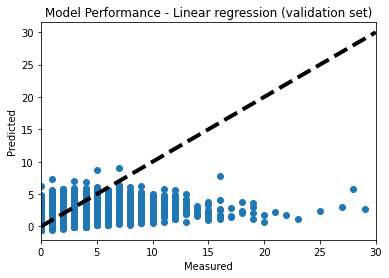

In [87]:
# linear regression on validation set
fig, ax = plt.subplots()

lin_pred_valid = lin_reg.predict(X_valid)

ax.scatter(y_valid, lin_pred_valid)
ax.plot([y_valid.min(), 30], [y_valid.min(), 30], 'k--', lw=4) #y_valid.max()
ax.set_xlim([0,30])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Model Performance - Linear regression (validation set)')
plt.show()

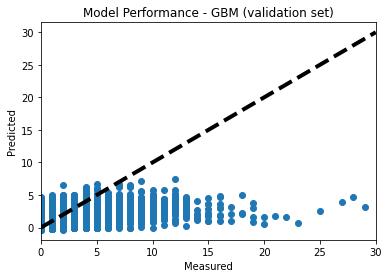

In [88]:
gbm_pred_valid = gbm_reg.predict(X_valid)

fig, ax = plt.subplots()
ax.scatter(y_valid, gbm_pred_valid)
ax.plot([y_valid.min(), 30], [y_valid.min(), 30], 'k--', lw=4) #y_valid.max()
ax.set_xlim([0,30])
ax.set_title('Model Performance - GBM (validation set)')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

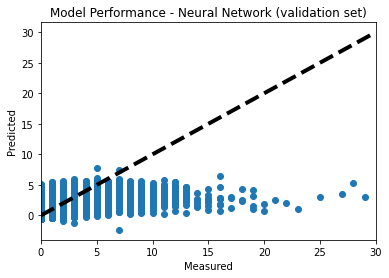

In [89]:
nn_pred_valid = model.predict(X_valid)

fig, ax = plt.subplots()
ax.scatter(y_valid, nn_pred_valid)
ax.plot([y_valid.min(), 30], [y_valid.min(), 30], 'k--', lw=4) #y_valid.max()
ax.set_xlim([0,30])
ax.set_title('Model Performance - Neural Network (validation set)')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##### Feature Significance

In [90]:
from statsmodels.api import OLS
OLS(y_train, X_train).fit().summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Target   R-squared (uncentered):                   0.604
Model:                            OLS   Adj. R-squared (uncentered):              0.604
Method:                 Least Squares   F-statistic:                          1.635e+04
Date:                Thu, 20 Aug 2020   Prob (F-statistic):                        0.00
Time:                        23:17:18   Log-Likelihood:                     -1.1750e+06
No. Observations:              697888   AIC:                                  2.350e+06
Df Residuals:                  697823   BIC:                                  2.351e+06
Df Model:                          65                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
COOP_sum               0.0014      0.002      0.627      0.530      -0.003       0.006
HLM_sum                0.0053      0.003      1.966      0.049    1.57e-05       0.011
OBNL_sum              -0.0057      0.002     -2.483      0.013      -0.010      -0.001
OMHM_sum              -0.0011      0.002     -0.566      0.571      -0.005       0.003
SHDM_sum               0.0003      0.002      0.117      0.907      -0.004       0.005
Target.L1              0.1630      0.002     84.601      0.000       0.159       0.167
Target.L2              0.1420      0.002     73.654      0.000       0.138       0.146
Target.L3              0.1280      0.002     66.320      0.000       0.124       0.132
Target.L4              0.1293      0.002     67.049      0.000       0.126       0.133
Target.L5              0.1298      0.002     67.111      0.000       0.126       0.134
Target.L6              0.1410      0.002     73.064      0.000       0.137       0.145
Target.L7              0.1562      0.002     81.239      0.000       0.152       0.160
Temp_DC_Mean           1.3508      0.053     25.272      0.000       1.246       1.456
Humid_percent_Mean     0.0554      0.013      4.156      0.000       0.029       0.081
Win_Dir_Mean          -0.0216      0.005     -4.551      0.000      -0.031      -0.012
Wind_Speed_Mean        0.0024      0.009      0.282      0.778      -0.014       0.019
Stn_Press_Mean         1.0411      0.053     19.509      0.000       0.937       1.146
Temp_DC_Max           -0.5989      0.031    -19.540      0.000      -0.659      -0.539
Humid_percent_Max     -0.0113      0.007     -1.684      0.092      -0.025       0.002
Win_Dir_Max           -0.0090      0.003     -2.872      0.004      -0.015      -0.003
Wind_Speed_Max        -0.0196      0.005     -3.633      0.000      -0.030      -0.009
Stn_Press_Max         -0.3580      0.028    -12.768      0.000      -0.413      -0.303
Temp_DC_Min           -0.9525      0.027    -35.149      0.000      -1.006      -0.899
Humid_percent_Min     -0.0253      0.008     -3.044      0.002      -0.042      -0.009
Win_Dir_Min            0.0020      0.003      0.595      0.552      -0.005       0.009
Wind_Speed_Min         0.0240      0.005      4.968      0.000       0.015       0.033
Stn_Press_Min         -0.7151      0.027    -26.190      0.000      -0.769      -0.662
Target_mean            0.2767      0.005     51.620      0.000       0.266       0.287
Target_median         -0.0025      0.005     -0.489      0.625      -0.012       0.007
Sum_age_0_14           0.4059      0.453      0.896      0.370      -0.482       1.294
Sum_age_15_64          0.6965      0.784      0.889      0.374      -0.840       2.233
Sum_age_65             0.4

Text(0.5, 1.0, 'Feature Importance; GBM')

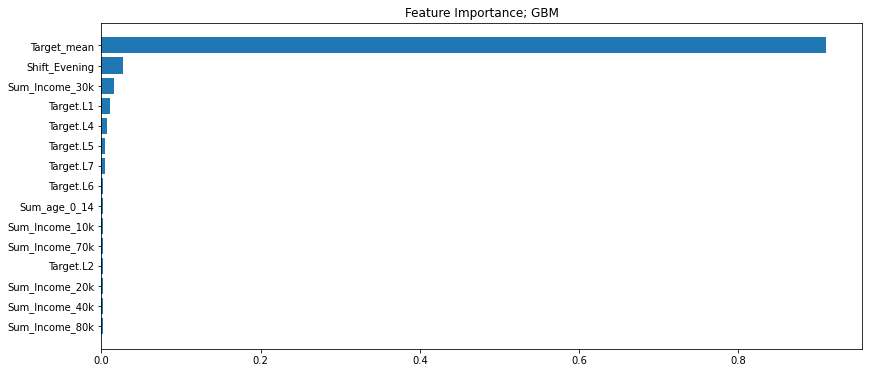

In [91]:
# Pour le GBM
feature_importance = gbm_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx_ = sorted_idx[-15:]
pos = np.arange(sorted_idx_.shape[0]) + .5
fig = plt.figure(figsize=(30, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx_], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx_])
plt.title('Feature Importance; GBM')